# PBL1. Fuzzy Logic Automatic Braking Controller

C:\Users\Georg\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


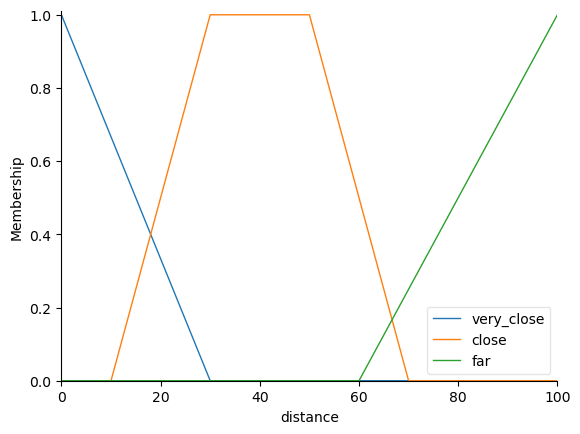

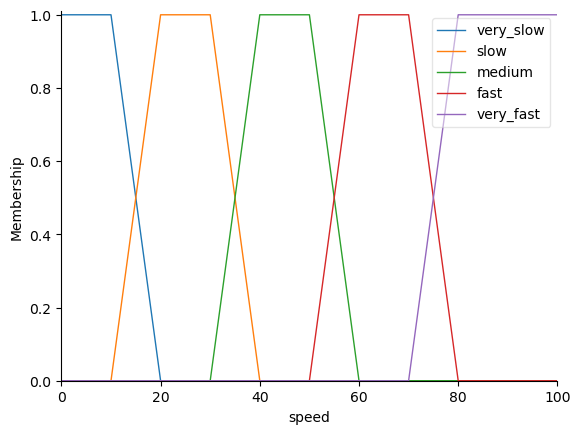

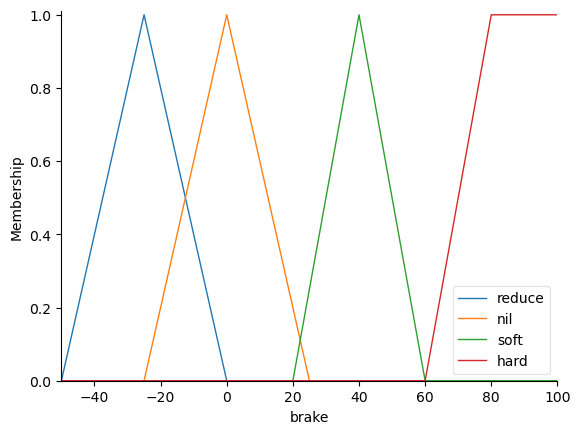

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import ipywidgets as widgets

### Creating the fuzzy sets
# Here, we define the ranges for three variables: distance, speed, and brake force.
# 'np.arange' creates arrays of values from 0 to 100 for distance and speed, and from -50 to 100 for brake force.
distance_range = np.arange(0, 101, 1)
speed_range = np.arange(0, 101, 1)
brake_range = np.arange(-50, 101, 1)

# Now, we create fuzzy variables for distance, speed, and brake force.
# 'ctrl.Antecedent' is used for input variables (distance and speed).
# 'ctrl.Consequent' is used for the output variable (brake).
distance = ctrl.Antecedent(distance_range, 'distance')
speed = ctrl.Antecedent(speed_range, 'speed')
brake = ctrl.Consequent(brake_range, 'brake')

### Generate fuzzy membership functions
# The following lines define the fuzzy membership functions for each fuzzy variable.
# 'fuzz.trimf' and 'fuzz.trapmf' create triangular and trapezoidal membership functions, respectively.

# For 'distance', three membership functions are defined: 'very_close', 'close', and 'far'.
distance['very_close'] = fuzz.trimf(distance.universe, [0, 0, 30])
distance['close'] = fuzz.trapmf(distance.universe, [10, 30, 50, 70])
distance['far'] = fuzz.trimf(distance.universe, [60, 100, 100])

# For 'speed', five membership functions are defined: 'very_slow', 'slow', 'medium', 'fast', 'very_fast'.
speed['very_slow'] = fuzz.trapmf(speed.universe, [0, 0, 10, 20])
speed['slow'] = fuzz.trapmf(speed.universe, [10, 20, 30, 40])
speed['medium'] = fuzz.trapmf(speed.universe, [30, 40, 50, 60])
speed['fast'] = fuzz.trapmf(speed.universe, [50, 60, 70, 80])
speed['very_fast'] = fuzz.trapmf(speed.universe, [70, 80, 100, 100])

# For 'brake', four membership functions are defined: 'reduce', 'nil', 'soft', 'hard'.
brake['reduce'] = fuzz.trimf(brake.universe, [-50, -25, 0])
brake['nil'] = fuzz.trimf(brake.universe, [-25, 0, 25])
brake['soft'] = fuzz.trimf(brake.universe, [20, 40, 60])
brake['hard'] = fuzz.trapmf(brake.universe, [60, 80, 100, 100])

# 'brake.defuzzify_method' sets the method used to derive a single output value from the fuzzy set.
# "centroid" is a common defuzzification method which returns the center of area under the curve.
brake.defuzzify_method = "centroid"

# The final lines are used to visualize the membership functions for each fuzzy variable.
# This is useful for understanding how each variable is partitioned into fuzzy sets.
distance.view()
speed.view()
brake.view()

In [2]:
### Rule base

# This section defines the rules for the fuzzy logic control system. 
# These rules determine how the system will interpret different combinations of input values.

# Rule 1:
# IF the distance is 'close' AND speed is 'very_slow' OR 'slow' OR 'medium',
# THEN brake 'soft'.
# This rule means that if the car is close to an object and moving at a slow to medium speed, 
# it should apply a soft braking force.
rule1 = ctrl.Rule((distance['close'] & speed['very_slow']) |
                  (distance['close'] & speed['slow']) |
                  (distance['close'] & speed['medium']),
                  brake['soft'])

# Rule 2:
# IF the distance is 'far' AND speed is 'very_slow' OR 'slow',
# THEN brake 'reduce'.
# This rule applies a reduced braking force when the car is far from the object and moving slowly.
rule2 = ctrl.Rule((distance['far'] & speed['very_slow']) |
                  (distance['far'] & speed['slow']),
                  brake['reduce'])

# Rule 3:
# IF the distance is 'far' AND speed is 'medium' OR 'fast' OR 'very_fast',
# THEN do not apply brake ('nil').
# When the car is far from the object and moving at a medium to high speed, 
# this rule suggests no braking is necessary.
rule3 = ctrl.Rule((distance['far'] & speed['medium']) |
                  (distance['far'] & speed['fast']) |
                  (distance['far'] & speed['very_fast']),
                  brake['nil'])

# Rule 4:
# IF the distance is 'very_close',
# THEN brake 'hard'.
# This rule is straightforward - if the car is very close to an object, 
# it should apply a hard brake, regardless of the speed.
rule4 = ctrl.Rule(distance['very_close'], brake['hard'])

# Adding the rules to the control system
# This line creates a control system that integrates the rules defined above.
brake_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])

34.715990944638826


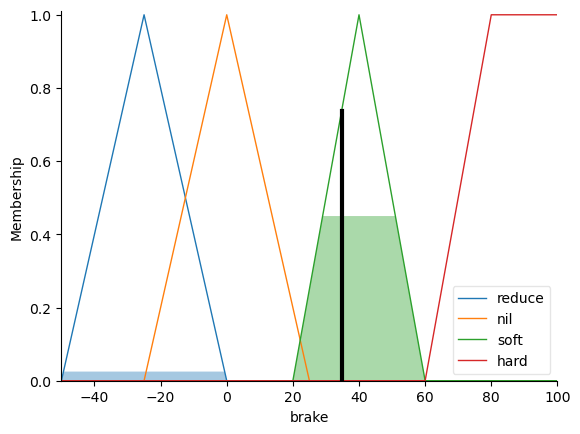

In [3]:
### Visualisation of output with test inputs
# Creating a simulation object based on the control system.
# This object allows us to simulate the behavior of the system with different inputs.
braking = ctrl.ControlSystemSimulation(brake_ctrl)

# Providing test inputs for the simulation.
# Here, we set the 'distance' to 61 meters and 'speed' to 1 km/h as an example.
braking.input['distance'] = 61
braking.input['speed'] = 1

# Computing the output based on the provided inputs.
# This step runs the fuzzy logic calculations based on the rules and inputs.
braking.compute()

# Printing the output value of the brake.
# This shows the degree to which the brake should be applied according to the fuzzy logic system.
print(braking.output['brake'])

# Visualizing how the control system responds to the given inputs.
# This visualization helps in understanding the system's output for the specific scenario.
brake.view(sim=braking)

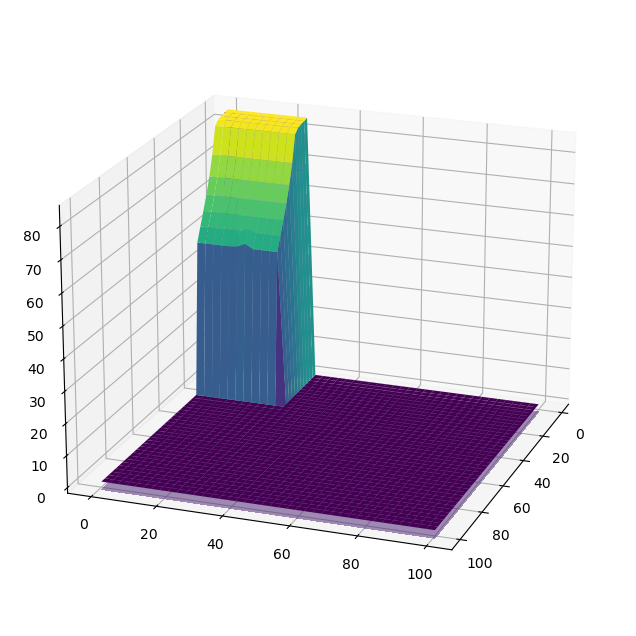

In [4]:
### Control space visualisation

# This section prepares the data for a 3D plot. 
# 'np.linspace' creates an array of 40 evenly spaced numbers from 0 to 100.
# These arrays represent all the possible values for distance and speed.
upsampled = np.linspace(0, 100, 40)

# 'np.meshgrid' creates a rectangular grid out of the arrays of distance and speed values.
# 'x' and 'y' will be the grid coordinates for plotting.
x, y = np.meshgrid(upsampled, upsampled)

# 'z' is initialized to store the brake force values corresponding to each (x, y) coordinate.
# It starts as a grid of zeros with the same shape as 'x' and 'y'.
z = np.zeros_like(x)

# This nested loop goes through each combination of distance and speed in the grid.
for i in range(11):
    for j in range(11):
        # Set the current values of distance and speed for the simulation.
        braking.input['distance'] = x[i, j]
        braking.input['speed'] = y[i, j]

        # Compute the brake force for the current combination of distance and speed.
        braking.compute()

        # Store the computed brake force in 'z' at the corresponding grid position.
        z[i, j] = braking.output['brake']

# Plotting the control surface in 3D.
# 'fig' is the figure object and 'ax' is the axes object for the plot.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 'plot_surface' plots the surface defined by 'x', 'y', and 'z'.
# It uses the 'viridis' colormap and some additional styling options.
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)

# 'contourf' adds filled contour plots to the surface at different offsets.
# These contours help in visualizing the variations in brake force across the control space.
cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

# Setting the viewing angle for the 3D plot.
ax.view_init(20, 20)


This code visualizes how the brake force output of the fuzzy control system varies across different values of distance and speed. The 3D plot and contours provide a comprehensive view of the control surface, illustrating the system's response under various conditions.

In the visualization:

- The **3D surface plot** represents the relationship between `distance`, `speed`, and the resulting `brake force`. This helps in understanding how the brake force changes as the vehicle's distance to an object and its speed vary.

- The **contour plots** on the sides of the 3D plot show cross-sections of this relationship at different levels, offering another perspective to comprehend how brake force is influenced by changes in either `distance` or `speed`.

Overall, this visualization is crucial for analyzing the effectiveness and behavior of the fuzzy logic controller in different driving scenarios, ensuring that the system reacts appropriately under various conditions.


In [5]:
### Interactive widget for further testing

# Defines a function to compute the brake force. It takes 'Distance' and 'Speed' as inputs.
def computeBraking(Distance, Speed):
    braking.input['distance'] = Distance  # Sets the distance input for the braking system.
    braking.input['speed'] = Speed        # Sets the speed input for the braking system.
    braking.compute()                     # Computes the brake force based on the inputs.
    return braking.output['brake']        # Returns the calculated brake force.

# Creates interactive sliders for Distance and Speed.
# As you adjust these sliders, the computeBraking function is called with the new values.
# This allows you to see how different distances and speeds affect the brake force.
widgets.interact(computeBraking, Distance=(1,100,1), Speed=(1,100,1))


interactive(children=(IntSlider(value=50, description='Distance', min=1), IntSlider(value=50, description='Spe…

<function __main__.computeBraking(Distance, Speed)>

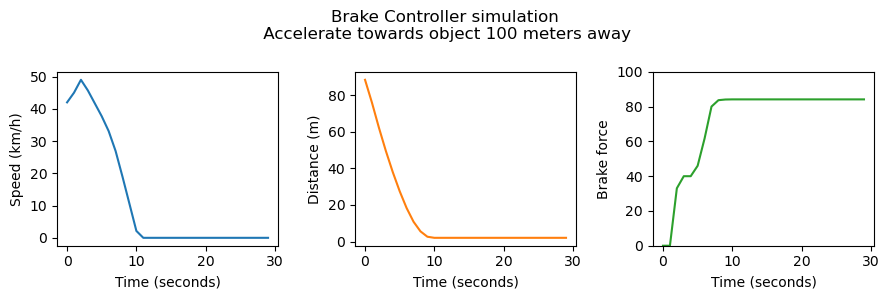

In [6]:
### Simulation and analysis

# Defining classes for lead and target cars to simulate their behavior
class LeadCar:
    def __init__(self):
        self.speed = 0  # Initial speed of the lead car
        self.pos = 0    # Initial position of the lead car

    def updatePos(self):
        # Update the position of the lead car based on its current speed
        self.pos += (self.speed / 3.6)  # Convert speed from km/h to m/s

class TargetCar:
    def __init__(self, leadCar: LeadCar):
        self.speed = 0             # Initial speed of the target car
        self.acceleration = 1      # Initial acceleration of the target car
        self.leadCar = leadCar     # Reference to the lead car
        self.pos = 0               # Initial position of the target car
        self.posFromLead = 0       # Initial distance from the lead car
        self.brakeFlag = False     # Flag to indicate if braking is occurring

    def updateSpeed(self, brakeStrength):
        # Update the speed of the target car based on the brake strength
        if brakeStrength > 1:
            self.speed -= max(brakeStrength / 10, 0)
            if self.acceleration > 0:
                self.acceleration -= 1 # Reset acceleration
            self.brakeFlag = True
        elif self.brakeFlag != True:
            self.acceleration += 1
            self.speed += self.acceleration
        self.speed = max(self.speed, 0)

    def updatePos(self):
        # Update the position of the target car and calculate its distance from the lead car
        self.pos += (self.speed / 3.6) # Convert from km/h to m/s
        self.posFromLead = (self.leadCar.pos - self.pos)

# Initializing the lead and target cars
leadCar = LeadCar()
targetCar = TargetCar(leadCar)

# Set initial conditions for the lead and target cars
leadCar.speed = 0
leadCar.pos = 100
targetCar.speed = 40
targetCar.pos = 0
brakeStrength = 0

# Define the simulation time and arrays to store data for plotting
time = 30
x = np.arange(0, time, 1)
brakes = np.zeros(time)
speed = np.zeros(time)
distance = np.zeros(time)

# Run the simulation over the specified time
for i in range(time):
    # Check for collision between the lead and target cars
    if targetCar.pos > (leadCar.pos - 1):
        break

    # Update positions of both cars and calculate the brake strength
    leadCar.updatePos()
    targetCar.updateSpeed(brakeStrength)
    targetCar.updatePos()

    # Determine the brake strength using the fuzzy logic controller
    brakeStrength = computeBraking(targetCar.posFromLead, targetCar.speed)
    
    # Store the speed, distance, and brake strength at each time step for plotting
    speed[i] = targetCar.speed
    distance[i] = targetCar.posFromLead
    brakes[i] = brakeStrength

# Plotting the simulation results to visualize the behavior of the target car
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(9,3))
# Speed plot
axs[0].plot(x, speed, color='tab:blue', label='Speed (km/h)')
axs[0].set_ylabel('Speed (km/h)')
axs[0].set_xlabel('Time (seconds)')
# Distance plot
axs[1].plot(x, distance, color='tab:orange', label='Relative distance')
axs[1].set_ylabel('Distance (m)')
axs[1].set_xlabel('Time (seconds)')
# Brake force plot
axs[2].plot(x, brakes, color='tab:green', label='Brake force')
axs[2].set_ylim([0,100])
axs[2].set_ylabel('Brake force')
axs[2].set_xlabel('Time (seconds)')
fig.suptitle('Brake Controller simulation\n Accelerate towards object 100 meters away')
fig.tight_layout()
plt.show()
